<a href="https://colab.research.google.com/github/huskeypm/cellmigration/blob/main/migration_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook for processing particle simulator results
(launched from github)

* Upload csv files from working directory to DL:
e.g.
> cp $FAUST:/home/pkekeneshuskey/source/cellmigration/run/231129/test.png.csv ~/DL/

or

> cp /home/pkekeneshuskey/source/cellmigration/run/231129/test.png.csv ~/DL/

* mount google drive to write data (just hit google drive button under Files)


* Hop to [section](#myCell) to process


In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
# mount drive 1st
import os
outPath='/content/drive/MyDrive/temp/'
if os.path.exists(outPath) is False:
  print("Be sure to mount google drive")

In [2]:
!git clone https://github.com/huskeypm/cellmigration
#!cd /content/cellmigration; git pull


Cloning into 'cellmigration'...
remote: Enumerating objects: 678, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 678 (delta 99), reused 94 (delta 50), pack-reused 510
Receiving objects: 100% (678/678), 10.48 MiB | 12.47 MiB/s, done.
Resolving deltas: 100% (436/436), done.


In [3]:
import sys
sys.path.append('/content/cellmigration')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import processData as pdat
cases = dict()
class empty:pass

In [44]:
!cd cellmigration; ls -lrt

/bin/bash: line 1: cd: cellmigration: No such file or directory
total 1252
-rw-r--r-- 1 root root   4111 Dec 11 20:26 README.md
-rw-r--r-- 1 root root   3267 Dec 11 20:26 README_1.md
-rw-r--r-- 1 root root  35149 Dec 11 20:26 LICENSE
-rw-r--r-- 1 root root   6081 Dec 11 20:26 batchProcess.py
-rw-r--r-- 1 root root  13074 Dec 11 20:26 brown_wnonbond.py
-rwxr-xr-x 1 root root  16847 Dec 11 20:26 brownian_v5.py
-rwxr-xr-x 1 root root  17420 Dec 11 20:26 brownian_v4.py
-rwxr-xr-x 1 root root  17425 Dec 11 20:26 brownian_v3.py
-rw-r--r-- 1 root root  14586 Dec 11 20:26 brownian_v2.py
-rw-r--r-- 1 root root  15659 Dec 11 20:26 concentration.py
-rw-r--r-- 1 root root  32129 Dec 11 20:26 calculator.py
-rw-r--r-- 1 root root    857 Dec 11 20:26 config.bash
-rw-r--r-- 1 root root 279866 Dec 11 20:26 conda_openmm_pytraj.ipynb
drwxr-xr-x 2 root root   4096 Dec 11 20:26 expt_analysis
-rw-r--r-- 1 root root   7216 Dec 11 20:26 lattice.py
-rw-r--r-- 1 root root  55819 Dec 11 20:26 histo.ipynb
-rw-r--

Partition file according to cases

In [5]:
dataFrameName = "test.png.csv"
dataFrameName = "subset.csv"
df = pd.read_csv(dataFrameName)

In [6]:
### pull out those without ATP in the title
#new_df = df[~df["col"].str.contains(word)]
nocrowder_noatp = df.loc[
     df['trajName'].str.contains("nocrowder")  &
    ~df['trajName'].str.contains("atp")
]

nocrowder_atp = df.loc[
     df['trajName'].str.contains("nocrowder")  &
     df['trajName'].str.contains("atp")
]

crowder_noatp = df.loc[
     df['trajName'].str.contains("^crowder")  &
    ~df['trajName'].str.contains("atp")
]
#print(crowder_noatp.tail())

crowder_atp = df.loc[
     df['trajName'].str.contains("^crowder")  &
     df['trajName'].str.contains("atp")
]


### Case: no crowders

In [ ]:
dataFrameName = "fig4.csv"
dataFrameName = "nocrowder.csv"

if False:
  df = pd.read_csv(dataFrameName)
else:
  df = nocrowder_noatp


[10.         12.5992105  15.87401052 20.         25.198421   31.74802104
 40.        ]
Assuming middle value is reference
x(3) = 20.000000


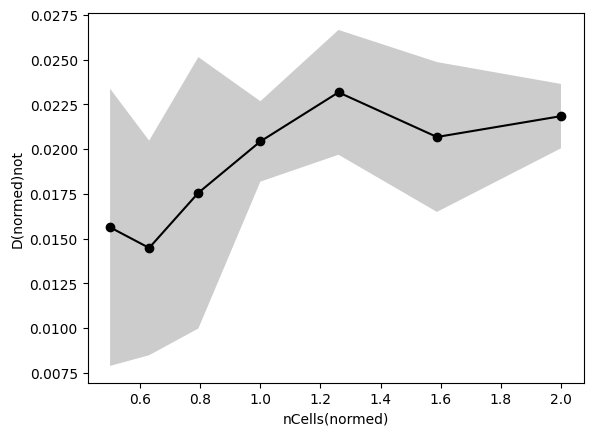

In [ ]:

# get all entries with a given key name
key = "nCells"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs = ProcessGroup(df,key)
cases[key] = case

PlotKey(case.conds,case.Ds,case.Dstds,key,normalize=True)



In [ ]:
get mean position

SyntaxError: ignored

### Introduce ATP into the equation

 <a class="anchor" name="myCell"></a>



In [ ]:
import pandas as pd
if False:
  dataFrameName = "nocrowder.csv"
  df = pd.read_csv(dataFrameName)
  dataFrameName = "nocrowder_atp.csv"
  dfATP = pd.read_csv(dataFrameName)
else:
  df = nocrowder_noatp
  dfATP=nocrowder_atp


In [ ]:
dfATP

,Unnamed: 0,trajName,tag,condVal,D,flux*A,Vol Frac
7,7,nocrowder_atp_cellRad3.174802_03,cellRad,3.174802,0.016289,-0.0013,0.99999
8,8,nocrowder_atp_cellRad5.039684_04,cellRad,5.039684,0.013623,-0.0012,0.99999
9,9,nocrowder_atp_nCells10.000000_04,nCells,10.000000,0.008260,-0.0009,0.99999
11,11,nocrowder_atp_cellRad2.000000_03,cellRad,2.000000,0.013582,-0.0008,0.99999
13,13,nocrowder_atp_cellRad5.039684_01,cellRad,5.039684,0.012766,-0.0012,0.99999
...,...,...,...,...,...,...,...
422,422,nocrowder_atp_cellAttr0.158740_02,cellAttr,0.158740,0.019100,-0.0013,0.99999
424,424,nocrowder_atp_nCells40.000000_04,nCells,40.000000,0.026520,-0.0024,0.99999
425,425,nocrowder_atp_cellAttr0.062996_03,cellAttr,0.062996,0.010245,-0.0015,0.99999
427,427,nocrowder_atp_nCells25.198421_02,nCells,25.198421,0.014551,-0.0016,0.99999


[ 2.5         3.14980262  3.96850263  5.          6.29960525  7.93700526
 10.        ]


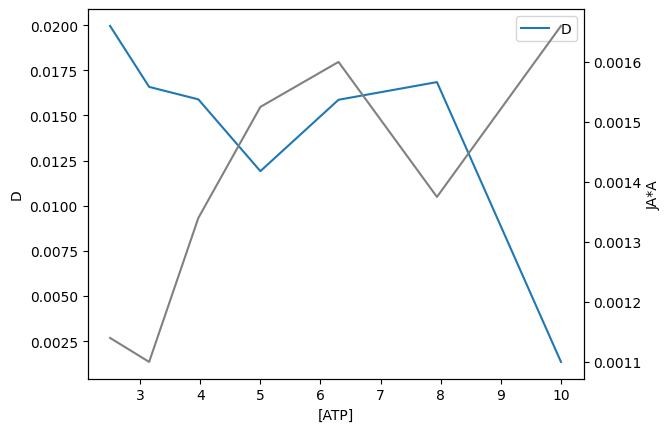

In [ ]:
case = empty()
case.conds,case.Ds,case.Dstds, case.JAs,case.volFracs = ProcessGroup(dfATP,"xScale")
#dfATP.xScale

fig,axl = plt.subplots()
axl.plot(case.conds,case.Ds,label='D')
axl.set_ylabel("D")
axl.set_xlabel("[ATP]")
axl.legend(loc=0)

# we use negative -1 since negative flux is going across toward right
axr = axl.twinx()
axr.plot(case.conds,-1 * case.JAs,'gray')
axr.set_ylabel("JA*A")

plt.gcf().savefig(outPath+"fig4_D_vs_ATP.png",dpi=300)

[10.         12.5992105  15.87401052 20.         25.198421   31.74802104
 40.        ]
[10.         12.5992105  15.87401052 20.         25.198421   31.74802104
 40.        ]
Assuming middle value is reference
x(3) = 20.000000
Assuming middle value is reference
x(3) = 20.000000


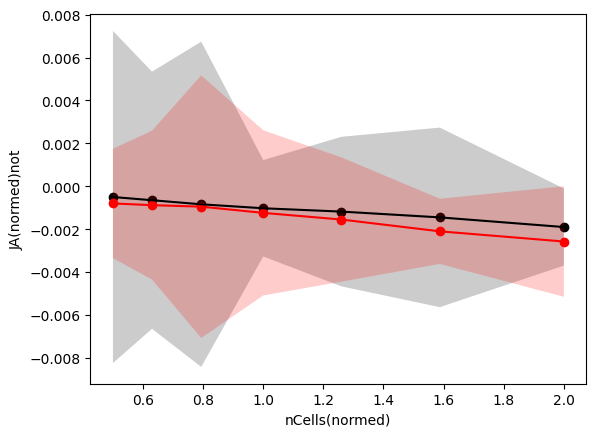

In [ ]:
# plotting two sets of data
# get all entries with a given key name
key = "nCells"

case = empty()
case.conds,case.Ds,case.Dstds, case.JAs, case.vFs = ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs = ProcessGroup(dfATP,key)
cases[key+"+atp"] = case

print("WARNING: using incorrect stderr")
case = cases[key+"-atp"]
PlotKey(case.conds,case.JAs,case.Dstds,key,normalize=True,mode="JA")

case = cases[key+"+atp"]
PlotKey(case.conds,case.JAs,case.Dstds,key,color='r',normalize=True,mode="JA")

plt.gcf().savefig(outPath+"fig4_nCells.png",dpi=300)


[2.         2.5198421  3.1748021  4.         5.0396842  6.34960421
 8.        ]
[2.         2.5198421  3.1748021  4.         5.0396842  6.34960421
 8.        ]
Assuming middle value is reference
x(3) = 4.000000
Assuming middle value is reference
x(3) = 4.000000


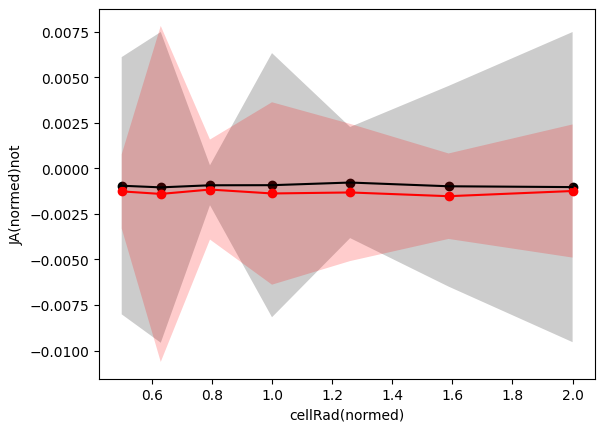

In [ ]:

key = "cellRad"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs  = ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs  = ProcessGroup(dfATP,key)
cases[key+"+atp"] = case


case = cases[key+"-atp"]
PlotKey(case.conds,case.JAs,case.Dstds,key,color='k',normalize=True,mode="JA")


case = cases[key+"+atp"]
PlotKey(case.conds,case.JAs,case.Dstds,key,color='r',normalize=True,mode="JA")


plt.gcf().savefig(outPath+"fig4_cellRad.png",dpi=300)

[0.05       0.06299605 0.07937005 0.1        0.1259921  0.15874011
 0.2       ]
[0.05       0.06299605 0.07937005 0.1        0.1259921  0.15874011
 0.2       ]
Assuming middle value is reference
x(3) = 0.100000
Assuming middle value is reference
x(3) = 0.100000


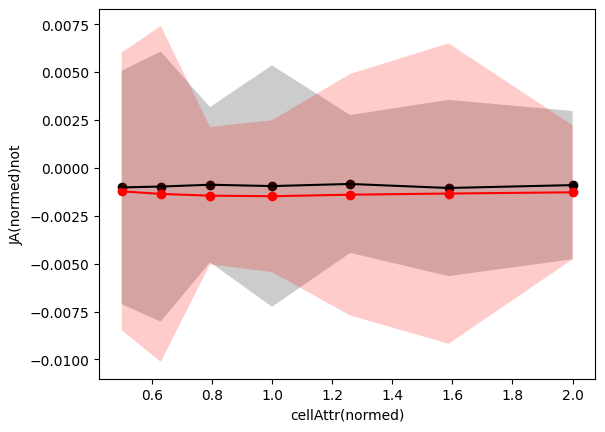

In [ ]:
key = "cellAttr"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs  = ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs  = ProcessGroup(dfATP,key)
cases[key+"+atp"] = case


case = cases[key+"-atp"]
PlotKey(case.conds,case.JAs,case.Dstds,key,color='k',normalize=True,mode="JA")


case = cases[key+"+atp"]
PlotKey(case.conds,case.JAs,case.Dstds,key,color='r',normalize=True,mode="JA")


plt.gcf().savefig(outPath+"fig4_cellAttr.png",dpi=300)

## CROWDERS WITH ATP

In [7]:
if False:
  dataFrameName = "crowder.csv"
  df = pd.read_csv(dataFrameName)
  dataFrameName = "crowder_atp.csv"
  dfATP = pd.read_csv(dataFrameName)
else:
  df = crowder_noatp
  dfATP = crowder_atp



In [31]:
df

,Unnamed: 0,trajName,tag,condVal,D,flux*A(reservoir),flux*A(crowd),Vol Frac,Area Frac
20,20,crowder_crowderRad10.000000_00,crowderRad,10.000000,-0.000111,-4.797652e-07,-1.192853e-09,0.434513,0.599669
21,21,crowder_crowderRad10.000000_01,crowderRad,10.000000,0.000112,-3.636613e-07,-1.197147e-09,0.434513,0.600162
22,22,crowder_crowderRad10.000000_02,crowderRad,10.000000,0.000059,-5.066009e-07,-1.146666e-09,0.434513,0.597313
23,23,crowder_crowderRad10.000000_03,crowderRad,10.000000,0.000063,-4.843959e-07,-1.226372e-09,0.434513,0.601141
24,24,crowder_crowderRad10.000000_04,crowderRad,10.000000,0.000118,-3.942160e-07,-1.249502e-09,0.434513,0.603497
25,25,crowder_crowderRad5.000000_00,crowderRad,5.000000,0.000208,-5.079135e-07,-1.023085e-09,0.858628,0.828947
26,26,crowder_crowderRad5.000000_01,crowderRad,5.000000,0.000127,-5.507721e-07,-1.011717e-09,0.858628,0.823706
27,27,crowder_crowderRad5.000000_02,crowderRad,5.000000,0.000134,-4.953643e-07,-1.026440e-09,0.858628,0.803247
28,28,crowder_crowderRad5.000000_03,crowderRad,5.000000,-0.000058,-6.124168e-07,-9.986720e-10,0.858628,0.822347
29,29,crowder_crowderRad5.000000_04,crowderRad,5.000000,0.000104,-5.722277e-07,-9.617929e-10,0.858628,0.824619


In [19]:
key = "nCrowders"

case = empty()
case.conds,case.Ds,case.Dstds, case.JAs, case.vFs  = pdat.ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds, case.JAs, case.vFs  = pdat.ProcessGroup(dfATP,key)
cases[key+"+atp"] = case



case = cases[key+"-atp"]
#PlotKey(case.conds,case.Ds,case.Dstds,key,normalize=False)
pdat.PlotKey(case.conds,case.JAs,case.Dstds,key,color='k',normalize=True,mode="JA")

case = cases[key+"+atp"]
#PlotKey(case.conds,case.Ds,case.Dstds,key,color='r',normalize=False)
pdat.PlotKey(case.conds,case.JAs,case.Dstds,key,color='r',normalize=True,mode="JA")


plt.gcf().savefig(outPath+"fig5_nCrowders.png",dpi=300)


RuntimeError: ignored

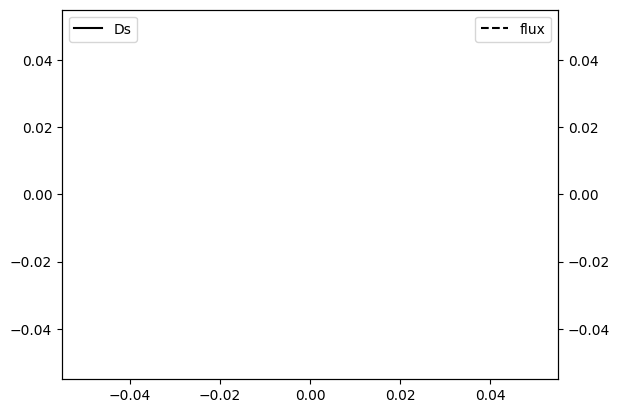

In [12]:
fig, axl = plt.subplots()
axl.plot(case.conds,case.Ds,'k-',label="Ds")
axl.legend(loc=2)
axr=axl.twinx()
axr.plot(case.conds,-1*case.JAs,'k--',label="flux")
axr.legend(loc=0)


[ 5.          6.29960525  7.93700526 10.        ]
JAs [1.         0.96485165 0.94451073 0.81375976]
[ 5.          6.29960525  7.93700526 10.        ]
+ATP JAs [0.26442225 0.17174603 0.09483262 0.20166161]


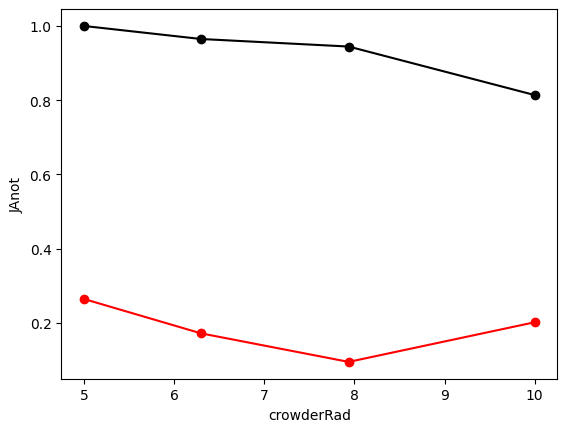

In [39]:
key = "crowderRad"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs  = pdat.ProcessGroup(df,key)
cases[key+"-atp"] = case

#print('JAs',case.JAs)
normFactor = np.min(case.JAs) # since negative
print('JAs',case.JAs/normFactor)

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs  = pdat.ProcessGroup(dfATP,key)
cases[key+"+atp"] = case
print('+ATP JAs',case.JAs/normFactor)

case = cases[key+"-atp"]
#pdat.PlotKey(case.conds,case.Ds,case.Dstds,key,normalize=False)
pdat.PlotKey(case.conds,case.JAs/normFactor,case.Dstds,key,normalize=False,mode="JA")

case = cases[key+"+atp"]
#pdat.PlotKey(case.conds,case.Ds,case.Dstds,key,color='r',normalize=False)
pdat.PlotKey(case.conds,case.JAs/normFactor,case.Dstds,key,color='r',normalize=False,mode="JA")

plt.gcf().savefig(outPath+"fig5_crowderRad.png",dpi=300)


#### Also do vs vol frac
if 0:
  plt.figure()
  case = cases[key+"-atp"]
  pdat.PlotKey(case.vFs,case.Ds,case.Dstds,key,normalize=False, altName="phi")

  case = cases[key+"+atp"]
  pdat.PlotKey(case.vFs,case.Ds,case.Dstds,key,color='r',normalize=False,altName="phi")


In [21]:
key = "crowderAttr"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs  = ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.vFs  = ProcessGroup(dfATP,key)
cases[key+"+atp"] = case


case = cases[key+"-atp"]
PlotKey(case.conds,case.Ds,case.Dstds,key,normalize=True)

case = cases[key+"+atp"]
PlotKey(case.conds,case.Ds,case.Dstds,key,color='r',normalize=True)

plt.gcf().savefig(outPath+"fig5_crowderAttr.png",dpi=300)

NameError: ignored

## Continuum data

- Run master on kant (test07-test10)
- See paper notes for more detail on repository
../solutions/test07/smol/0001/info.yaml:Deff_membrane: 0.49443361495120397
../solutions/test08/smol/0001/info.yaml:Deff_membrane: 0.7730293910002057
../solutions/test09/smol/0001/info.yaml:Deff_membrane: 0.7963113880422519
../solutions/test10/smol/0001/info.yaml:Deff_membrane: 0.9866307129197737
Singularity> grep phi_memb ../solutions/test*/smol/0001/info.yaml
../solutions/test07/smol/0001/info.yaml:phi_membrane: 0.6681145173651292
../solutions/test08/smol/0001/info.yaml:phi_membrane: 0.8539840575456275
../solutions/test09/smol/0001/info.yaml:phi_membrane: 0.8772177500681925
../solutions/test10/smol/0001/info.yaml:phi_membrane: 0.9933862126810031


In [ ]:
import matplotlib.pylab as plt
import numpy as np
phis = np.array([0.4108862126810036, 0.6681145173651292, 0.8539840575456275, 0.8772177500681925, 0.9933862126810031])
Ds = np.array([0.403642231410656, 0.49443361495120397, 0.7730293910002057, 0.7963113880422519, 0.9866307129197737])

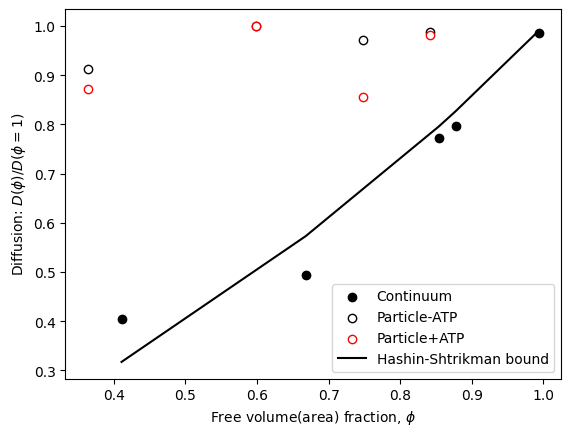

In [ ]:



plt.scatter(phis,Ds,facecolor='k',label="Continuum")

case = cases['crowderRad'+"-atp"]
plt.scatter(case.vFs,case.Ds/np.max(case.Ds),facecolor='w',edgecolor='k',
            label="Particle-ATP")
case = cases['crowderRad'+"+atp"]
plt.scatter(case.vFs,case.Ds/np.max(case.Ds),facecolor='w',edgecolor='r',
            label="Particle+ATP")


plt.plot(phis,2*phis/(3-phis),'k',label="Hashin-Shtrikman bound")
plt.legend(loc=0)
plt.xlabel("Free volume(area) fraction, $\phi$")
plt.ylabel("Diffusion: $D(\phi)/D(\phi=1)$")

plt.gcf().savefig(outPath+"fig7_DvsPhi.png",dpi=300)


Widths

Created test11-13
/info.yaml
totflux_A_pore: 0.05925859045541587
pkekeneshuskey@kant:requests/$ grep totflux_A_pore ../solutions/test12/smol/0001/info.yaml
totflux_A_pore: 0.07531812128985557
pkekeneshuskey@kant:requests/$ grep totflux_A_pore ../solutions/test13/smol/0001/info.yaml
totflux_A_pore: 0.0876739876632738


5, 7, and 9 pore widths; assuming it's 11 high



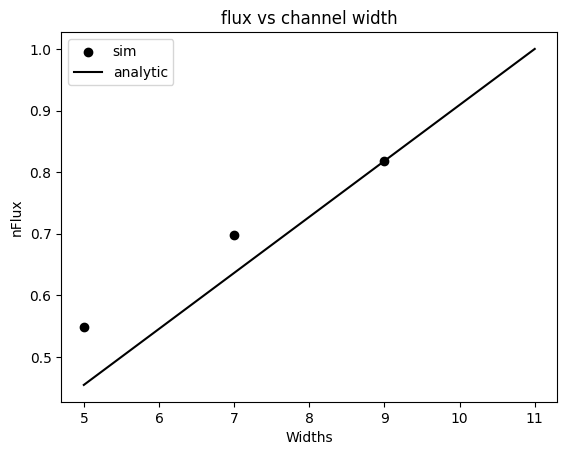

In [ ]:
widths=[5,7,9]
fluxes = np.array([0.059,0.075,0.088])
max=11 # include this in widths next time
print("WARNING: use actual value")
maxFlux = fluxes[2]*max/widths[2]

import matplotlib.pylab as plt
import numpy as np
plt.scatter(widths,fluxes/maxFlux, facecolor='k',label="sim")
validwidths = np.array([5,7,9,max])
plt.plot(validwidths,validwidths/max,'k',label='analytic')
plt.ylabel("nFlux")
plt.xlabel("Widths")
plt.title("flux vs channel width")
plt.legend(loc=0)


plt.gcf().savefig(outPath+"fig7_JvsW.png",dpi=300)


In [ ]:
maxFlux

1.0755555555555556